# **Richter's Predictor: Modeling Earthquake Damage - Geographical Data**

In this notebook we will explore the geographical data we have and produce vizualizations that reflect the geographical nature of the data. Basically, we are matching our raw data with open source map data and combine both into a map that shows the havoc the 2015 Gorkha earthquake caused in 11 Provinces. Here is a quick outline how we will procede in this notebook:
- Load Libraries & Setup
- Merge Model & Map data
    - Preparation Model Data
    - Preparation Map Data
    - Putting it all together
- Data Visualization

## Load Libraries & Setup

In [74]:
# First we load all necessary libraries
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import shapefile as shp  


import warnings
warnings.filterwarnings('ignore')

import numpy as np

import matplotlib            
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

RSeed = 42
print(matplotlib.rcParams['backend'])

module://ipykernel.pylab.backend_inline


**Note:** In order to work with the map data we created a separate virtual environment in order to prevent conflicts in our package dependencies. 

## Import Model & Map Data

We start with importing our model data before we will continue with the additional map data for visualization.

### Preparation Model Data

In [75]:
df = pd.read_pickle("data/model/data_model.csv")

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607201 entries, 0 to 607200
Data columns (total 65 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   district_id                             607201 non-null  category
 1   vdcmun_id                               607201 non-null  category
 2   ward_id                                 607201 non-null  category
 3   legal_ownership_status                  607201 non-null  category
 4   count_families                          607201 non-null  float64 
 5   has_secondary_use                       607201 non-null  float64 
 6   has_secondary_use_agriculture           607201 non-null  int64   
 7   has_secondary_use_hotel                 607201 non-null  int64   
 8   has_secondary_use_rental                607201 non-null  int64   
 9   has_secondary_use_institution           607201 non-null  int64   
 10  has_secondary_use_school        

In [80]:
df.district_id.nunique()

11

We will now aggregate our data to district level by averaging the information per district. The resulting data will contain only information on the 11 districts but keep all columns and average the values per column.

In [ ]:
df_district = df.groupby(['district_id']).mean().reset_index()

In [78]:
df_district.head()

,district_id,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,...,ia_area_height,age_log,height_log,area_log,ia_area_height_log,structure_cat_weak,structure_cat_strong,structure_5cat_weak,structure_5cat_strong,structure_cat_weak_emp
0,12,0.918208,0.061790,0.030369,0.018215,0.001754,0.000925,0.000032,0.000191,0.000287,...,5661.074742,2.677008,2.609359,5.847327,8.456686,2.104951,3.509761,2.017513,2.545968,2.186360
1,20,0.944089,0.093786,0.056257,0.026580,0.005702,0.001549,0.000474,0.001202,0.000055,...,6311.364996,2.415313,2.676082,5.898246,8.574328,4.123572,6.507642,2.756062,3.745149,4.420925
2,21,0.943624,0.105056,0.076024,0.019947,0.005024,0.000663,0.000150,0.000641,0.000192,...,5906.583046,2.765703,2.716954,5.817667,8.534621,2.086606,3.277114,2.030508,2.540695,2.105462
3,22,1.163604,0.116383,0.077204,0.027013,0.007114,0.000928,0.000330,0.001402,0.000206,...,6790.533292,2.763126,2.787534,5.875014,8.662548,2.160718,3.132509,2.046479,2.490896,2.243984
4,23,1.014882,0.124714,0.076936,0.038454,0.004458,0.000832,0.000240,0.001199,0.000183,...,7294.330258,2.830569,2.781558,5.949912,8.731471,2.246763,3.250670,2.056877,2.467541,2.384638


In the first column above we see our district IDs. In order to match the data with the map data and to have meaningful labels in our vizualizations later we will re-code the IDs into their English names. 

In [79]:
district_names = {"district_id":{
                                12:'Okhaldhunga', 20:'Sindhuli', 21:'Ramechhap', 22:'Dolakha', 23:'Sindhupalchok', 
                                24:'Kabhrepalanchok', 28:'Nuwakot', 29:'Rasuwa', 30:'Dhading', 31:'Makawanpur', 36:'Gorkha'
                                }}
df_district = df_district.replace(district_names)

We are now finished with the preparation of our model data and can move on with our map data.

## Preparation Map Data

Let us start with importing the map data and explore a little bit what we have there.

In [83]:
# Import map data and print number of rows
sf = shp.Reader("shapefiles/npl_admbnda_districts_nd_20201117")
len(sf.shapes())

77

We see that there are 77 rows in our map data. We only have data on 11 districts and therefore have to drop the remaining rows later.

In [84]:
# Print shape type
sf.shapeType

5

The shapes we find in our map data are polygons and contain the information about the shape and geographical location of the districts. 

In [85]:
# Print a single record from the map data 
sf.records()[1]

Record #1: [2.37939222279, 0.113604358347, 'Arghakhanchi', 'NP0550', '', '', '', 'Lumbini', 'NP05', 'Nepal', 'NP', datetime.date(2020, 11, 17), datetime.date(2020, 11, 17), None]

We see that there is more information on each of the 77 districts in the data. Especially the English name of the ditricts will come in handy soon when we match the two datasets. Let us create a first little visualization of the map data. 

In [86]:
# Define function that prints map based on the coordinates.
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

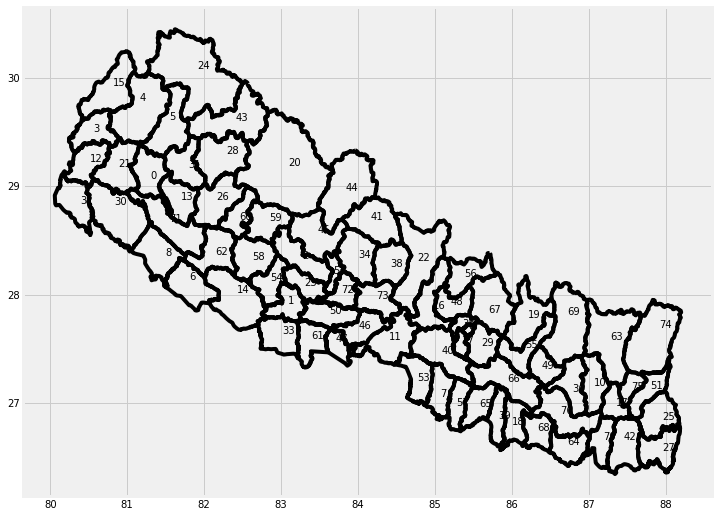

In [87]:
# Call function defined above
plot_map(sf)

Above we see a map of Nepal. As mentioned earlier we do not have data on the whole area of Nepal but only 11 of those 77 districts. We will adapt our data structure accordingly in the next steps.

In [88]:
geo = gpd.read_file("shapefiles/Level_1")

We again import the map data into a different kind of format so we can better adjust it to our needs.

In [89]:
geo.sample(10)

,Shape_Leng,Shape_Area,DIST_EN,DIST_PCODE,DIST_REF,DIST_ALT1E,DIST_ALT2E,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
35,1.359646,0.037851,Kathmandu,NP0327,None,None,None,Bagmati,NP03,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((85.45051 27.81365, 85.45081 27.81309..."
63,3.540370,0.317177,Sankhuwasabha,NP0109,None,None,None,Province 1,NP01,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((87.01841 27.95406, 87.01941 27.95335..."
70,2.005210,0.108072,Sunsari,NP0106,None,None,None,Province 1,NP01,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((87.23816 26.87577, 87.23919 26.87557..."
64,2.153621,0.116129,Saptari,NP0215,None,None,None,Province 2,NP02,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((86.56417 26.78960, 86.56453 26.78917..."
37,1.159587,0.036255,Lalitpur,NP0325,None,None,None,Bagmati,NP03,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((85.32101 27.68705, 85.32153 27.68685..."
8,2.620600,0.184235,Bardiya,NP0558,None,None,None,Lumbini,NP05,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((81.29419 28.67338, 81.29464 28.67329..."
48,1.997580,0.109383,Nuwakot,NP0328,None,None,None,Bagmati,NP03,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((85.13517 28.08414, 85.13577 28.08407..."
29,2.152101,0.127364,Kabhrepalanchok,NP0324,None,None,None,Bagmati,NP03,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((85.54976 27.75599, 85.54971 27.75576..."
53,2.292194,0.128192,Parsa,NP0234,None,None,None,Province 2,NP02,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((84.56527 27.46316, 84.56662 27.46244..."
11,3.372199,0.204779,Chitawan,NP0335,None,None,None,Bagmati,NP03,Nepal,NP,2020-11-17,2020-11-17,None,"POLYGON ((84.62030 27.88054, 84.62065 27.88051..."


We see that we get the same data as in the sample preview above but in a better accessible format. Before we move on with merging our two data sources we have a quick look on the English district names we have in the data. From the print-out below we see that they match nicely with the English names we assigned to our district IDs earlier.

In [90]:
geo['DIST_EN'].unique()

array(['Achham', 'Arghakhanchi', 'Baglung', 'Baitadi', 'Bajhang',
       'Bajura', 'Banke', 'Bara', 'Bardiya', 'Bhaktapur', 'Bhojpur',
       'Chitawan', 'Dadeldhura', 'Dailekh', 'Dang', 'Darchula', 'Dhading',
       'Dhankuta', 'Dhanusha', 'Dolakha', 'Dolpa', 'Doti', 'Gorkha',
       'Gulmi', 'Humla', 'Ilam', 'Jajarkot', 'Jhapa', 'Jumla',
       'Kabhrepalanchok', 'Kailali', 'Kalikot', 'Kanchanpur',
       'Kapilbastu', 'Kaski', 'Kathmandu', 'Khotang', 'Lalitpur',
       'Lamjung', 'Mahottari', 'Makawanpur', 'Manang', 'Morang', 'Mugu',
       'Mustang', 'Myagdi', 'Nawalparasi East', 'Nawalparasi West',
       'Nuwakot', 'Okhaldhunga', 'Palpa', 'Panchthar', 'Parbat', 'Parsa',
       'Pyuthan', 'Ramechhap', 'Rasuwa', 'Rautahat', 'Rolpa',
       'Rukum East', 'Rukum West', 'Rupandehi', 'Salyan', 'Sankhuwasabha',
       'Saptari', 'Sarlahi', 'Sindhuli', 'Sindhupalchok', 'Siraha',
       'Solukhumbu', 'Sunsari', 'Surkhet', 'Syangja', 'Tanahu',
       'Taplejung', 'Terhathum', 'Udayapur'], 

We can now continue with merging our datasets.

### Putting it all together

We will now merge both datasets on the English district names and keep all information from both datasets.

In [91]:
geodata = geo.merge(df_district, how='right', left_on=['DIST_EN'], right_on=['district_id'])

Lets us have a quick look at what we gt now.

In [92]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Shape_Leng                              11 non-null     float64 
 1   Shape_Area                              11 non-null     float64 
 2   DIST_EN                                 11 non-null     object  
 3   DIST_PCODE                              11 non-null     object  
 4   DIST_REF                                0 non-null      object  
 5   DIST_ALT1E                              0 non-null      object  
 6   DIST_ALT2E                              0 non-null      object  
 7   ADM1_EN                                 11 non-null     object  
 8   ADM1_PCODE                              11 non-null     object  
 9   ADM0_EN                                 11 non-null     object  
 10  ADM0_PCODE                              11 n

This worked out well. In the printout above we can see that we now have a dataframe that contains information from both datasets combined. Printing another little map with some colors helps us better imagine where we stand now.

<AxesSubplot:>

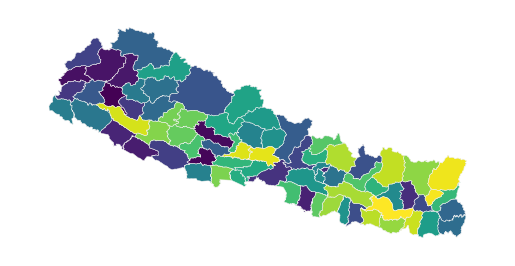

In [93]:
gplt.choropleth(geo, hue='DIST_EN')

From the examplary map above we see that we are now able to fill shapes in the map with colors based on the data we have on them. Still our dataset contains information about all 77 districts in Nepal. We can fix this by filtering our data to the relevant rows.

<AxesSubplot:>

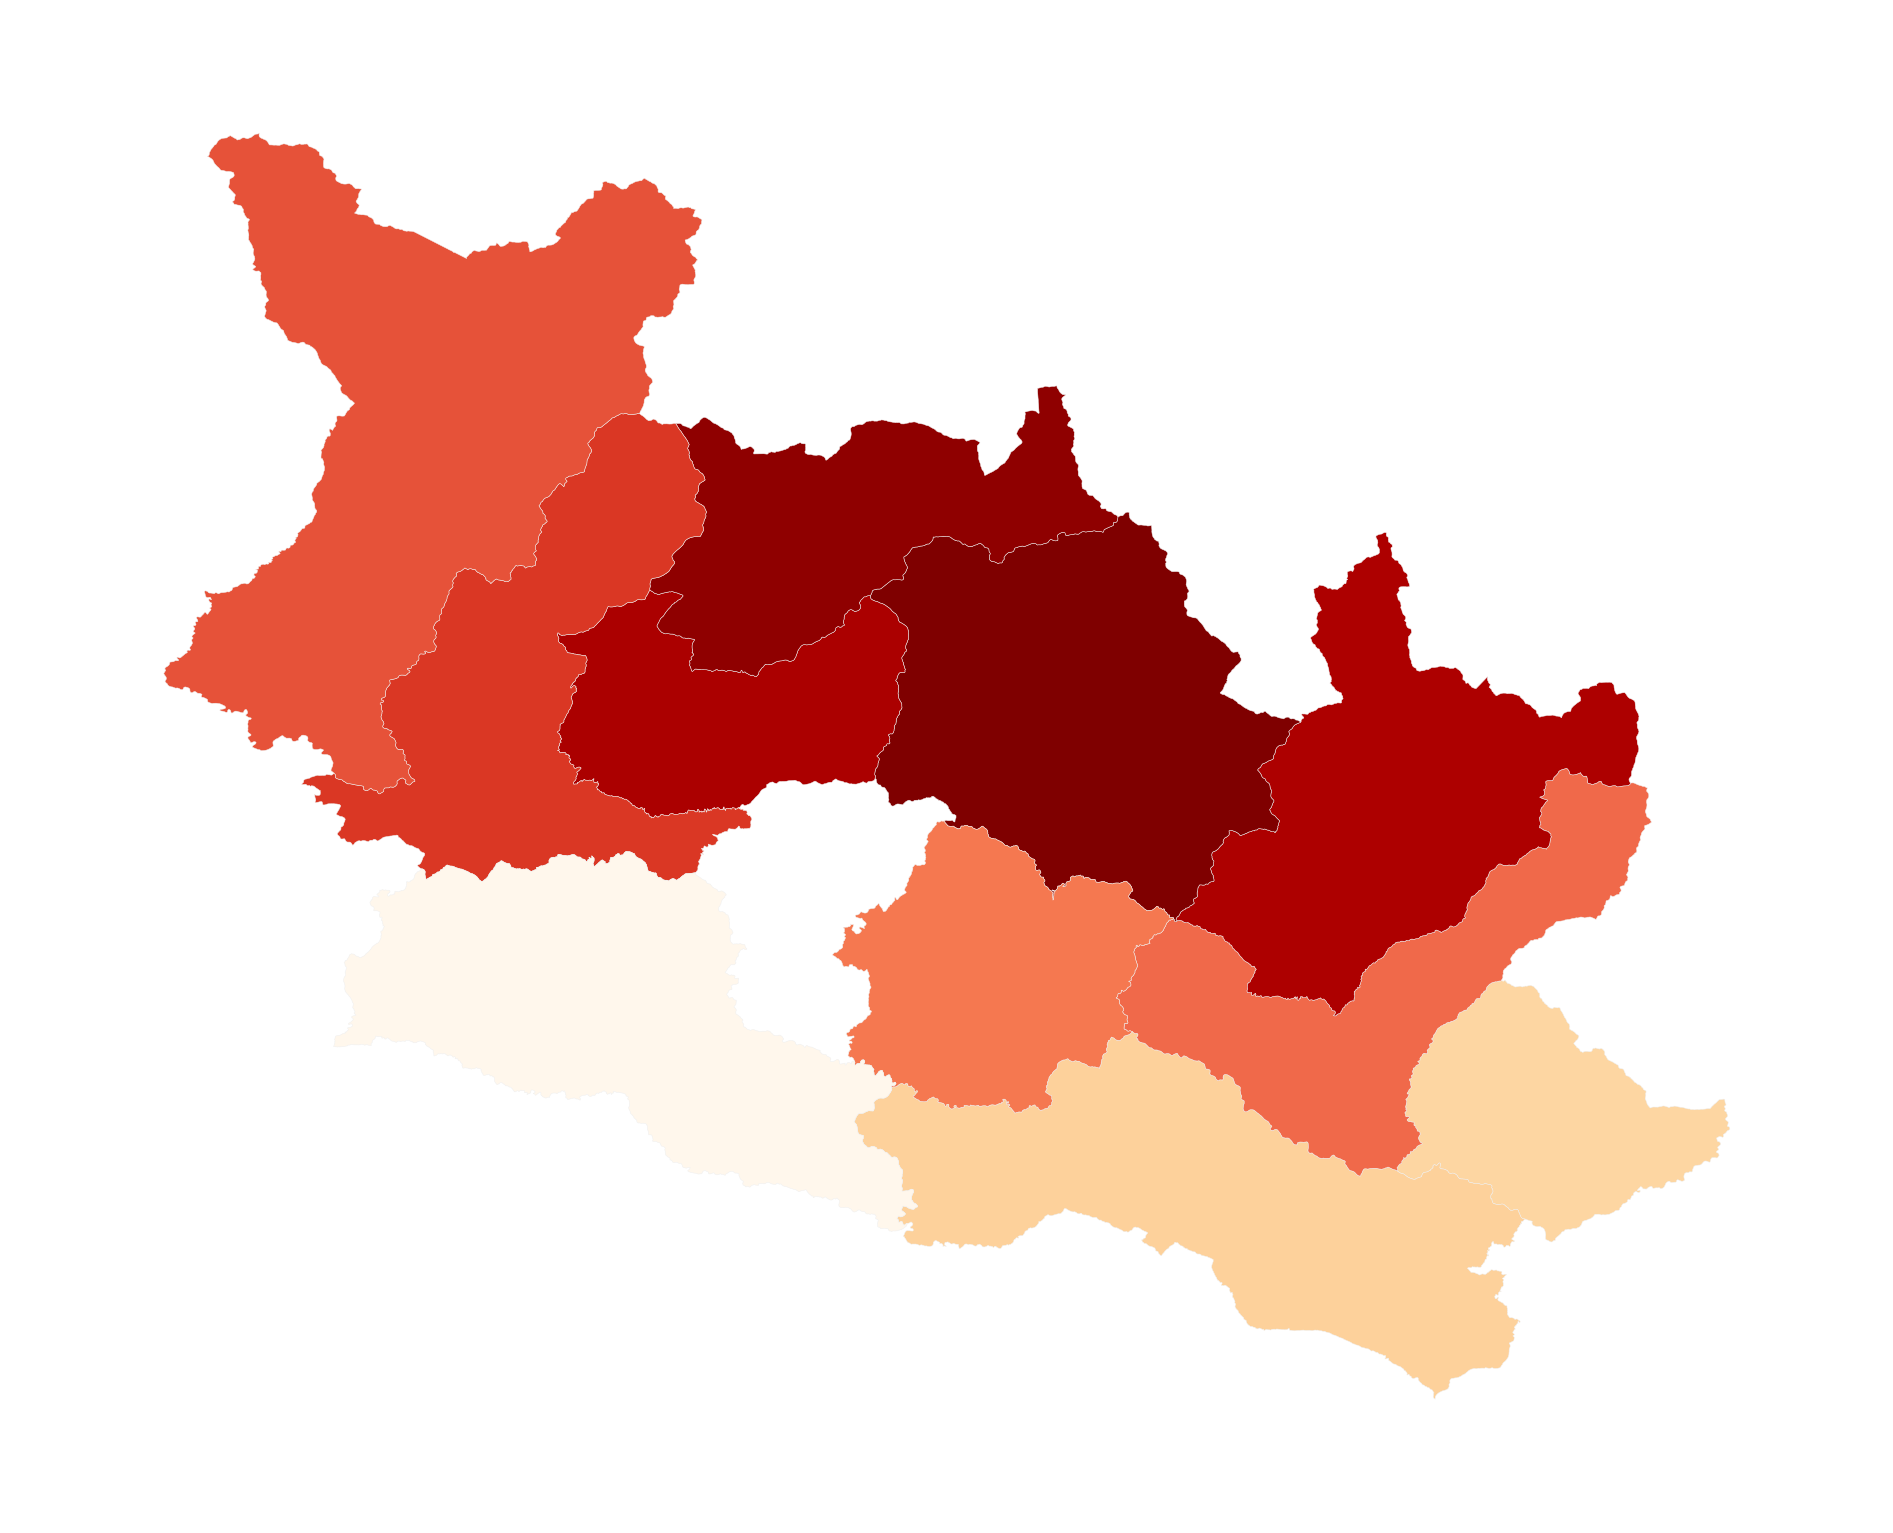

In [94]:
plotdata = geodata[geodata['DIST_EN'].isin(['Okhaldhunga', 'Sindhuli', 'Ramechhap', 'Dolakha', 'Sindhupalchok', 'Kabhrepalanchok', 'Nuwakot', 'Rasuwa', 'Dhading', 'Makawanpur', 'Gorkha'])]
PALETTE = 'OrRd'

gplt.choropleth(plotdata, hue = geodata['damage_grade'], cmap = PALETTE, figsize = (30,30))

This map above looks already quite like what we need. We are only displaying the 11 districts we have data on and are able to color our map according to the damage the 2015 Gorkha earthquake caused.

## Data Visualization

We will now further modify our data in order to create a good looking visualization. As some text for orientation on the map would be nice we calculate the centroids of each of our shapes so we can align our data labels with the centroids of the shapes.

In [96]:
geodata['coords'] = geodata['geometry'].apply(lambda x: x.centroid.coords[:])
geodata['coords'] = [coords[0] for coords in geodata['coords']]

geodata.sample(10)

,Shape_Leng,Shape_Area,DIST_EN,DIST_PCODE,DIST_REF,DIST_ALT1E,DIST_ALT2E,ADM1_EN,ADM1_PCODE,ADM0_EN,...,age_log,height_log,area_log,ia_area_height_log,structure_cat_weak,structure_cat_strong,structure_5cat_weak,structure_5cat_strong,structure_cat_weak_emp,coords
0,1.642184,0.098150,Okhaldhunga,NP0113,None,None,None,Province 1,NP01,Nepal,...,2.677008,2.609359,5.847327,8.456686,2.104951,3.509761,2.017513,2.545968,2.186360,"(86.41865880580423, 27.32950216466255)"
10,4.097603,0.335545,Gorkha,NP0436,None,None,None,Gandaki,NP04,Nepal,...,2.834484,2.663721,5.896268,8.559989,2.554900,3.947980,2.172760,2.796619,2.591890,"(84.79017724868417, 28.31882733455596)"
2,2.825117,0.142891,Ramechhap,NP0321,None,None,None,Bagmati,NP03,Nepal,...,2.765703,2.716954,5.817667,8.534621,2.086606,3.277114,2.030508,2.540695,2.105462,"(86.17737055267864, 27.513614204097628)"
8,3.452651,0.174889,Dhading,NP0330,None,None,None,Bagmati,NP03,Nepal,...,2.811845,2.679535,5.754263,8.433797,2.467940,4.039027,2.136326,2.826056,2.643532,"(84.96016062002536, 27.954707601146378)"
1,3.399550,0.226333,Sindhuli,NP0320,None,None,None,Bagmati,NP03,Nepal,...,2.415313,2.676082,5.898246,8.574328,4.123572,6.507642,2.756062,3.745149,4.420925,"(85.94376845075001, 27.201467012248063)"
5,2.152101,0.127364,Kabhrepalanchok,NP0324,None,None,None,Bagmati,NP03,Nepal,...,2.947128,2.846602,5.981648,8.828249,2.613848,3.445799,2.123519,2.526630,3.101409,"(85.61948320688475, 27.535356518688552)"
9,3.186771,0.223146,Makawanpur,NP0331,None,None,None,Bagmati,NP03,Nepal,...,2.490605,2.610004,5.989101,8.599106,4.412823,5.918364,2.786141,3.522592,5.296877,"(85.07919130810744, 27.469965237321475)"
6,1.997580,0.109383,Nuwakot,NP0328,None,None,None,Bagmati,NP03,Nepal,...,2.829063,2.793315,5.886799,8.680114,2.324372,3.448711,2.096007,2.657477,2.499195,"(85.23538741482933, 27.91507339682857)"
7,2.448489,0.137946,Rasuwa,NP0329,None,None,None,Bagmati,NP03,Nepal,...,2.683717,2.671513,5.968711,8.640224,2.500150,4.715331,2.084227,3.060363,2.132558,"(85.41594722931659, 28.18324833630412)"
4,2.562983,0.228384,Sindhupalchok,NP0323,None,None,None,Bagmati,NP03,Nepal,...,2.830569,2.781558,5.949912,8.731471,2.246763,3.250670,2.056877,2.467541,2.384638,"(85.73962898244332, 27.914972584786966)"


With some more formatting and tweaking we now get a really good looking map with colors and labels.

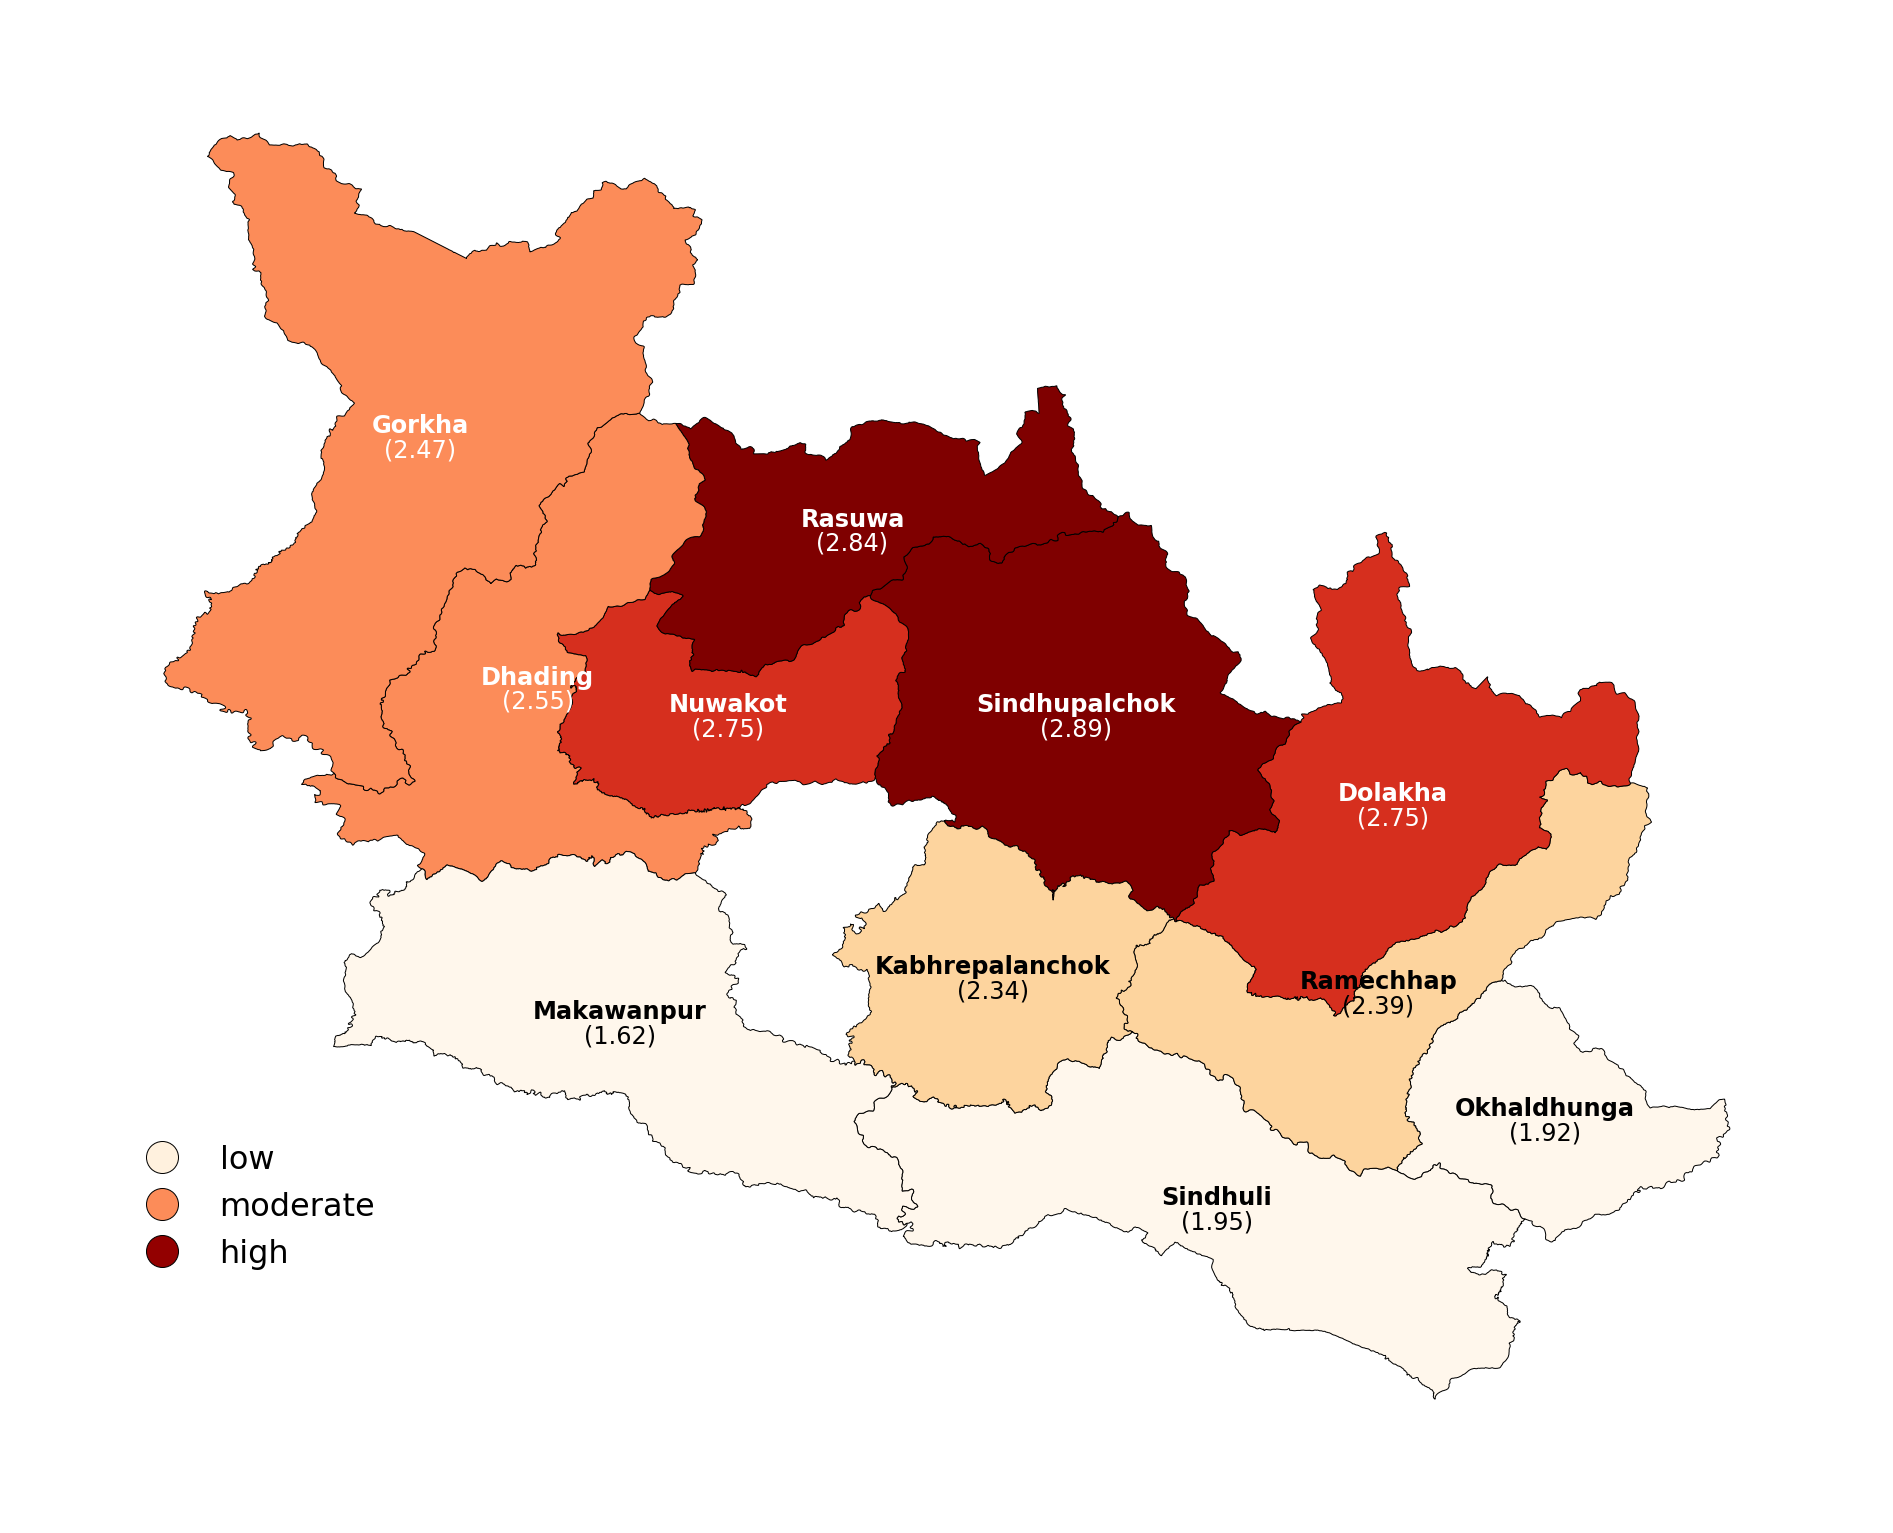

In [97]:
import geoplot.crs as gcrs

plotdata = geodata[geodata['DIST_EN'].isin(['Okhaldhunga', 'Sindhuli', 'Ramechhap', 'Dolakha', 'Sindhupalchok', 'Kabhrepalanchok', 'Nuwakot', 'Rasuwa', 'Dhading', 'Makawanpur', 'Gorkha'])]
PALETTE = 'OrRd'

#projection=gcrs.AlbersEqualArea()

gplt.choropleth(plotdata,
                hue=geodata['damage_grade'], cmap=PALETTE,
                figsize=(30,30), linewidth=1, edgecolor='black',
                legend=True, scheme='quantiles',
                    legend_kwargs={"frameon": False, 
                                   "fontsize": 32, 
                                   'markersize': 32, 
                                   'loc': 3, 
                                   'bbox_to_anchor': (0.05, 0.15, 0., 0.)},
                    legend_values=[0.2, 2, 3.8],
                    legend_labels=["low", "moderate", "high"])

for _, row in plotdata.iterrows():

  hue = round(row['damage_grade'],2)
  
  plt.text(s=row['DIST_EN'], x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', fontdict = {
               'weight': 'bold', 
               'size': 24, 
               'c': 'white' if hue>=2.4 else 'black'
           })
                                                                                                    
  plt.text(s='(' + f'{hue:,}' + ')', x=row['coords'][0],y = row['coords'][1] - 0.035 ,
          horizontalalignment='center', fontdict = {
              'size': 24, 
              'c': 'white' if hue>=2.4 else 'black'})

plt.savefig('figures/maps/Level_1-Mean_Damage.png', transparent=True, dpi=200)

On the map we can now see how the 2015 Gorkha eatrhquake affected buildings in the different districts we have data on.  

**Summary:**
- The darker the fill color in the map the higher the average damage was.
- The earthquake damaged buildings in the northern area of the map worse than it did in the south
- Buildings in districts Rasuwa and Sindhupalchok on average were damaged most
- On average buildings in the district of Makawanpur showed to be the least impacted after the earthquake